In [1]:
import os 
os.chdir('../')
from src.datasets.dataloader import get_dataset 
import ml_collections

import yaml
import torch
from os import path as pt
from src.utils import get_experiment_dir, save_obj

/home/hanglou/ac3/envs/PathChar_GAN/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import the configuration file, where the model, dataset and model hyperparatmers are specified. Here we illstrate our pipeline and test metrics with `RCGAN` on the `Geometric Brownian Motion` dataset. 

In [2]:
config_dir = 'configs/' + 'train_gan.yaml'
with open(config_dir) as file:
        config = ml_collections.ConfigDict(yaml.safe_load(file))
config.dataset = 'GBM'
config.algo = 'RCGAN'


In [3]:
#create train and test dataloader.
train_dl, test_dl = get_dataset(config, num_workers=4)

data shape: torch.Size([64, 50, 2])


To train the model, one can simply by calling `trainer.fit()`. Here we skip the training step and use a trained model, as we mainly aims to illustrate the evaluation. 

In [4]:
from src.baselines.models import get_trainer
trainer = get_trainer(config, train_dl, test_dl)
get_experiment_dir(config)
generator = trainer.G
generator.load_state_dict(torch.load(pt.join(
            config.exp_dir, 'generator_state_dict.pt'))) # load trained generator


RCGAN
GBM_RCGAN
GENERATOR: LSTMGenerator(
  (rnn): LSTM(5, 32, num_layers=3, batch_first=True)
  (linear): Linear(in_features=32, out_features=2, bias=True)
  (initial_nn): Sequential(
    (0): ResFNN(
      (network): Sequential(
        (0): ResidualBlock(
          (linear): Linear(in_features=5, out_features=32, bias=True)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): ResidualBlock(
          (linear): Linear(in_features=32, out_features=32, bias=True)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (2): Tanh()
        (3): Linear(in_features=32, out_features=96, bias=True)
      )
    )
    (1): Tanh()
  )
  (initial_nn1): Sequential(
    (0): ResFNN(
      (network): Sequential(
        (0): ResidualBlock(
          (linear): Linear(in_features=5, out_features=32, bias=True)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): ResidualBlock(
          (linear): Linear(in_features=32, out_features=32

<All keys matched successfully>

Prepare real and synthetic data for evaluations.

In [6]:
# generate some fake data
from src.evaluations.plot import *
from src.evaluations.evaluations import *
real_data = torch.cat([loader_to_tensor(train_dl),
                          loader_to_tensor(test_dl)])
idx = torch.randint(real_data.shape[0], (10000,))
real_test_dl = DataLoader(TensorDataset(
            real_data[idx[-2000:]]), batch_size=128)
fake_test_dl = fake_loader(generator, num_samples=2000,
                                n_lags=config.n_lags, batch_size=128, config=config)
x_real, x_fake = loader_to_tensor(real_test_dl), loader_to_tensor(fake_test_dl)

torch.Size([2000, 50, 2])


# Visualization

### Samples plot

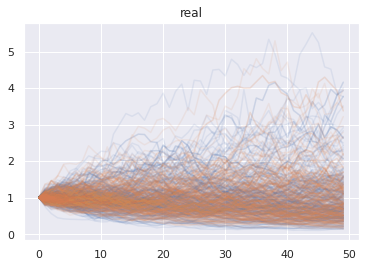

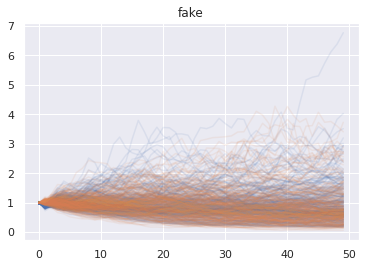

In [9]:
plot_samples(real_test_dl, fake_test_dl, config,plot_show = True)

### T-sne

/home/hanglou/ac3/envs/PathChar_GAN/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hanglou/ac3/envs/PathChar_GAN/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.361219
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.263611
[t-SNE] KL divergence after 300 iterations: 1.268760


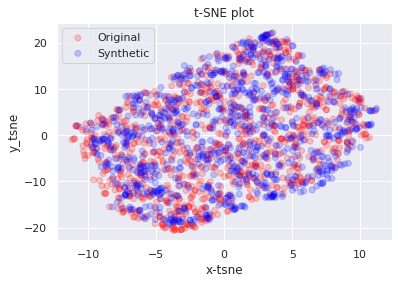

In [12]:
visualization(real_test_dl,fake_test_dl,config,plot_show =True)

# Stylised facts

### Histogram

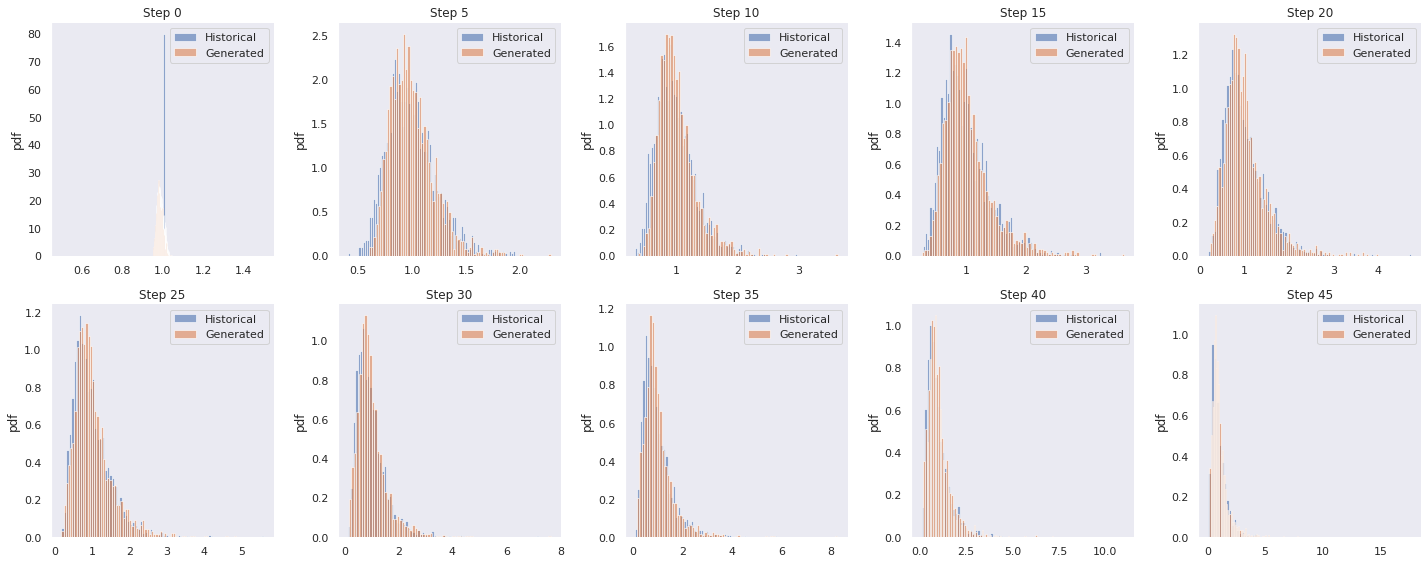

In [13]:
fig = plot_hists_marginals(x_real,x_fake)

The plot above illustrate the marginal distribution comparisons across 
various time steps.
Essentially we can quantify this by the marginal distribution loss: 

In [14]:
Marginal_loss = to_numpy(HistoLoss(x_real[:, 1:, :], n_bins=50, name='marginal_distribution')(x_fake[:, 1:, :]))
print('Marginal Loss = ', Marginal_loss)

Marginal Loss =  0.08439675


### Autocorrelation

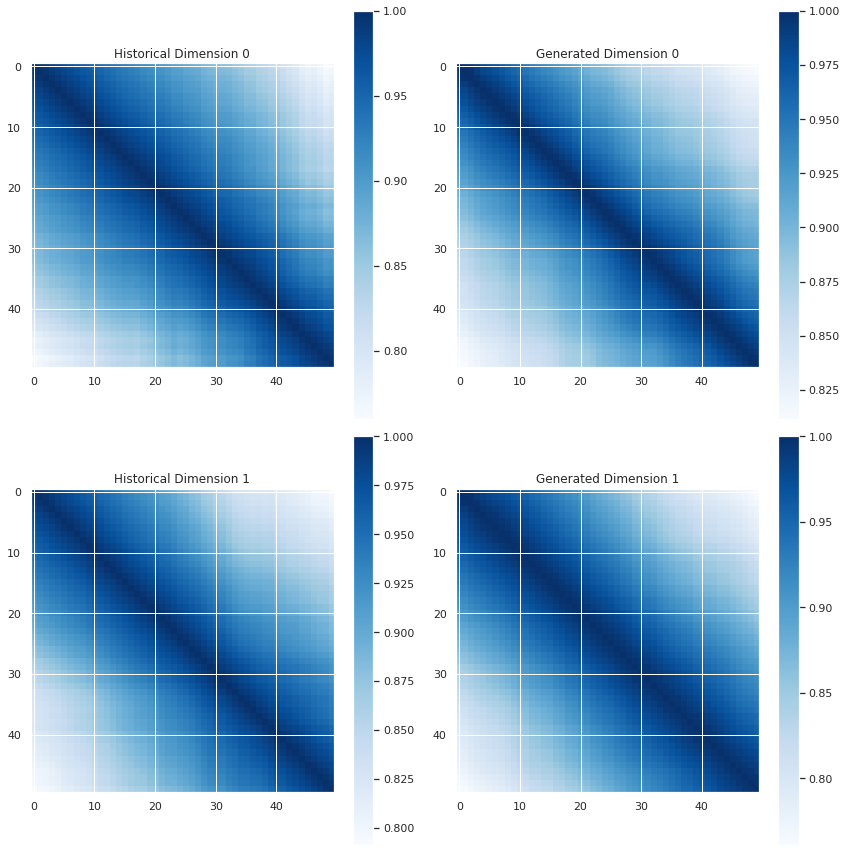

In [18]:
 compare_acf_matrix(real_test_dl,fake_test_dl, config)

The above plots demonstrated the quality of the generated sample in terms of autocorrelation. Correspondingly, we have the loss

In [19]:
acf_loss = to_numpy(ACFLoss(x_real, name='auto_correlation')(x_fake))
print('autocorrelation Loss = ', acf_loss)

autocorrelation Loss =  0.114078194


# ML based score

### Discriminative score

A post-hoc LSTM are trained to distinguish the real and generated time series. The discriminative score is reported as the classification error on the test dataset. Larger the discriminative score indicate the fake time series is easier to be distinguish.

In [25]:
real_train_dl = DataLoader(TensorDataset(
            real_data[idx[:-2000]]), batch_size=128)
fake_train_dl = fake_loader(generator, num_samples=8000,
                                        n_lags=config.n_lags, batch_size=128, config=config)
discriminative_score,_ = compute_discriminative_score(
            real_test_dl, real_test_dl, fake_test_dl, fake_test_dl, config, 10, 1, epochs=30, batch_size=128)

torch.Size([8000, 50, 2])
Discriminator(
  (rnn): GRU(2, 10, batch_first=True)
  (linear): Linear(in_features=10, out_features=2, bias=True)
)
Epoch 1/30
------------------------------
train Loss: 0.6973 Acc: 0.5000
validation Loss: 0.6921 Acc: 0.5210
Epoch 2/30
------------------------------
train Loss: 0.6921 Acc: 0.5225
validation Loss: 0.6920 Acc: 0.5045
Epoch 3/30
------------------------------
train Loss: 0.6922 Acc: 0.5098
validation Loss: 0.6919 Acc: 0.5058
Epoch 4/30
------------------------------
train Loss: 0.6921 Acc: 0.5088
validation Loss: 0.6918 Acc: 0.5068
Epoch 5/30
------------------------------
train Loss: 0.6919 Acc: 0.5090
validation Loss: 0.6917 Acc: 0.5098
Epoch 6/30
------------------------------
train Loss: 0.6918 Acc: 0.5110
validation Loss: 0.6916 Acc: 0.5112
Epoch 7/30
------------------------------
train Loss: 0.6917 Acc: 0.5112
validation Loss: 0.6915 Acc: 0.5122
Epoch 8/30
------------------------------
train Loss: 0.6916 Acc: 0.5122
validation Loss: 0.69

In [26]:
print('discriminative score = ', np.round(discriminative_score,4))

discriminative score =  0.0268


### Predictive score 

Using the synthetic dataset, we train a post-hoc sequence-prediction model (by optimizing a 2-layer LSTM) to predict future sequence.  Then, we evaluate the trained model on the original dataset. Performance is measured in terms of the mean
absolute error (MAE).

In [28]:
p_score_mean, _ = compute_predictive_score(
            real_train_dl, real_test_dl, fake_train_dl, fake_test_dl, config, 32, 2, epochs=50, batch_size=128)

predictor(
  (rnn): LSTM(2, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=10, bias=True)
)
Epoch 1/50
------------------------------
train Loss: 0.5968
validation Loss: 0.4171
Epoch 2/50
------------------------------
train Loss: 0.2824
validation Loss: 0.2175
Epoch 3/50
------------------------------
train Loss: 0.1780
validation Loss: 0.1810
Epoch 4/50
------------------------------
train Loss: 0.1559
validation Loss: 0.1677
Epoch 5/50
------------------------------
train Loss: 0.1446
validation Loss: 0.1593
Epoch 6/50
------------------------------
train Loss: 0.1374
validation Loss: 0.1544
Epoch 7/50
------------------------------
train Loss: 0.1320
validation Loss: 0.1509
Epoch 8/50
------------------------------
train Loss: 0.1279
validation Loss: 0.1486
Epoch 9/50
------------------------------
train Loss: 0.1247
validation Loss: 0.1468
Epoch 10/50
------------------------------
train Loss: 0.1222
validation Loss: 0.1451
Epoch 11/50
--------

In [29]:
print('predictive score = ', np.round(p_score_mean,4))

predictive score =  0.1496


# Signature based score

### Sig-MMD score

Distance based score based on the signature MMD with RBF kernel.

In [30]:
sig_mmd = Sig_mmd(x_real, x_fake, depth=5)

In [31]:
print('sig_mmd score =', to_numpy(sig_mmd))

sig_mmd score = 0.06866670162957522


### Sig-W1 score

Distance based score based on the Sig-W1 metric.

In [32]:
sig_w1 = to_numpy(SigW1Loss(x_real,name='SigW1',depth=5,augmentations=(),normalise=False)(x_fake))

In [33]:
print('Sig-W1 score =', sig_w1)

Sig-W1 score = 4.6110673
